In [ ]:
import numpy as np
import math
import scipy as sp
from scipy import integrate
import random
import matplotlib.pyplot as plt

In [ ]:
class fluidDynamics:
  '''

  This class models fluid flow using overrelaxation techniques

  '''

  def __init__(self, n, Vo, viscosity, plateLocation, relaxationParameter):
    self.n = n #matrix will be n*n
    self.Vo = Vo
    self.viscosity = viscosity
    self.relaxationParameter = relaxationParameter
    self.frontLocation = plateLocation[0]
    self.backLocation = plateLocation[1]
    self.topLocation = plateLocation[2]
    self.psiValues = np.zeros((n, n)) #indexed by i,j
    self.omegaValues = np.zeros((n,n))
    self.residuals = np.zeros((n,n))
    self.gridSpacing = 1/(n - 1) #vertex centered grid
    self.initializePsi()
    self.sweepCount = 0
    

  def initializePsi(self):
    for i in range(0, self.n-1):
      for j in range(0, self.n-1):
        self.psiValues[i][j] = self.Vo * j * self.gridSpacing 

  def contourPlotPsi(self):
    i = np.linspace(0, 1, self.n)
    j = np.linspace(0, 1, self.n)
    I, J = np.meshgrid(i, j, indexing='ij')

    fig, ax = plt.subplots()
    CS = ax.contour(I, J, self.psiValues, 37)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Psi')

  def contourPlotOmega(self):
    i = np.linspace(0, 1, self.n)
    j = np.linspace(0, 1, self.n)
    I, J = np.meshgrid(i, j, indexing='ij')

    fig, ax = plt.subplots()
    CS = ax.contourf(I, J, self.omegaValues)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Omega')


  def showVals(self):
    print("psi:")
    print(self.psiValues)
    print("omega:")
    print(self.omegaValues)

  def interiorPsi(self,i,j): #SOR for interior psi values
      sumOfNeighbors = self.psiValues[i+1][j]+self.psiValues[i,j+1]+self.psiValues[i-1][j]+self.psiValues[i][j-1]

      self.psiValues[i][j] = self.relaxationParameter*(1/4)*(sumOfNeighbors + (self.gridSpacing**2)*self.omegaValues[i][j])
        
  def interiorOmega(self,i,j): #SOR for interior omega values
      sumOfNeighbors = self.omegaValues[i+1][j]+self.omegaValues[i,j+1]+self.omegaValues[i-1][j]+self.omegaValues[i][j-1]
      dPsiOverDj = (self.psiValues[i][j+1]-self.psiValues[i][j-1])/(2*self.gridSpacing)
      dOmegaOverDi = (self.omegaValues[i+1][j]-self.omegaValues[i-1][j])/(2*self.gridSpacing)
      dPsiOverDi = (self.psiValues[i+1][j]-self.psiValues[i-1][j])/(2*self.gridSpacing)
      dOmegaOverDj = (self.omegaValues[i][j+1]-self.omegaValues[i][j-1])/(2*self.gridSpacing)

      self.omegaValues[i][j] = self.relaxationParameter*(1.0/4.0)*(sumOfNeighbors - 
                               ((self.gridSpacing ** 2.0)*(1.0/self.viscosity)*(dPsiOverDj*dOmegaOverDi - dPsiOverDi*dOmegaOverDj)))

  def centerLineBCPsi(self, i, j):
    #BC for bottom line. At these points, psi is 0 
    self.psiValues[i][j] = 0

  def centerLineBCOmega(self, i, j):
    #BC for bottom line. At these points, omega is 0
    self.omegaValues[i][j] = 0

  def upstreamBCPsi(self, i, j):
    #i = 0
    #BC for upstream surface
    #at these points, dPsi/dx = 0 ; therefore --> the psi value will be the same as the next point down stream
    self.psiValues[i][j] = self.psiValues[i+1][j]

  def upstreamBCOmega(self, i, j):
    #i = 0
    #at these points, omega = 0
    self.omegaValues[i][j] = 0

  def upperBCPsi(self, i, j):
    #j = n -1
    #BC for upper wall surface
    #At these points, dPsi/di = Vo --> therefore the BC Psi values will differ from the points
    #directly under them by Vo * gridSpacing

    #dPsi/dj = Vo  and dPsi/dj = (psi(i, j) - psi(i, j-1))/gridSpacing
    #Vo = (psi(i, j) - psi(i, j-1))/gridSpacing
    #so... psi(i, j) = psi(i, j-1) + Vo * gridSpacing
    
    self.psiValues[i][j] = self.psiValues[i][j-1] + self.Vo*self.gridSpacing

  def upperBCOmega(self, i, j):
    #j = n -1
    #BC for upper wall surface
    #omege = 0 at these points
    self.omegaValues[i][j] = 0

  def downstreamBCPsi(self, i, j):
    #i = n-1
    #at these points, dPsi/di = 0 ; therefore --> the psi value will be the same as the neit point directly upstram
    self.psiValues[i][j] = self.psiValues[i-1][j]

  def downstreamBCOmega(self, i, j):
    #i = n-1
    #at these points, dOmega/di = 0 ; therefore --> the omega value will be the same as the neit point directly upstram
    self.omegaValues[i][j] = self.omegaValues[i-1][j]

  def upstreamPlateBCPsi(self, i, j):
    #at any point on the plate, psi = 0
    self.psiValues[i][j] = 0

  def upstreamPlateBCOmega(self, i, j):
    #omega Value depends on adjacent Psi Value(in -x direction)
    self.omegaValues[i][j] = (-2/(self.gridSpacing**2))*self.psiValues[i-1][j]

  def downstreamPlateBCPsi(self, i, j):
    #at any point on the plate, psi = 0
    self.psiValues[i][j] = 0

  def downstreamPlateBCOmega(self, i, j):
    #omega Value depends on adjacent Psi Value(in +x direction)
    self.omegaValues[i][j] = (-2/(self.gridSpacing**2))*self.psiValues[i+1][j]

  def upperPlateBCPsi(self, i, j):
    #at any point on the plate, psi = 0
    self.psiValues[i][j] = 0

  def upperPlateBCOmega(self, i, j):
    #omega Value depends on adjacent Psi Value(in +j direction)
    self.omegaValues[i][j] = (-2/(self.gridSpacing**2))*self.psiValues[i][j+1]

  def residualPsi(self, i, j):
    """
    1. Calculate Laplace of Psi
    2. Add laplace with our estimation of laplace on Psi which is = -w
    3. Difference is our error
    laplace definition: calculate the second dirivatives in i and j direction, and add them together"""
    secondDerivativei = (self.psiValues[i-1][j] - 2*self.psiValues[i][j] + self.psiValues[i+1][j])/(self.gridSpacing**2)
    secondDerivativej = (self.psiValues[i][j-1] - 2*self.psiValues[i][j] + self.psiValues[i][j+1])/(self.gridSpacing**2)
    residual = secondDerivativei + secondDerivativej + self.omegaValues[i][j]
    return residual

  def norm(self):
    "sum squares of all residuals and then take square root of that sum"
    norm = 0
    for i in range(1, self.n-1):
      for j in range(1, self.n-1):
        norm += self.residualPsi(i, j)**2

    return norm**(1/2) 


  def sweep(self):
    #Updates Psi and Omega values at each grid point
    self.sweepCount += 1

    for i in range(0, self.n):
      for j in range(0, self.n):
        if j == 0:
          #centerLine
          self.centerLineBCPsi(i, j)
          self.centerLineBCOmega(i, j)
        elif i == 0:
          #upstream surface
          self.upstreamBCPsi(i, j)
          self.upstreamBCOmega(i, j)
        elif j == self.n-1:
          #upper surface
          self.upperBCPsi(i, j)
          self.upperBCOmega(i, j)
        elif i == self.n-1:
          # downstream
          self.downstreamBCPsi(i, j)
          self.downstreamBCOmega(i, j)

        #on plate condition
        elif i*self.gridSpacing >= self.frontLocation and i*self.gridSpacing <= self.backLocation and j*self.gridSpacing <= self.topLocation:
          if i*self.gridSpacing >= self.frontLocation and i*self.gridSpacing < (self.frontLocation + self.gridSpacing):
            #upstream plate surface
            self.upstreamPlateBCPsi(i, j)
            self.upstreamPlateBCOmega(i, j)
          elif i*self.gridSpacing <= self.backLocation and i*self.gridSpacing > (self.backLocation - self.gridSpacing):
            #downstream plate surface
            self.downstreamPlateBCPsi(i, j)
            self.downstreamPlateBCOmega(i, j)
          elif j*self.gridSpacing <= self.topLocation and j*self.gridSpacing > (self.topLocation - self.gridSpacing):
            #upper plate surface
            self.upperPlateBCPsi(i, j)
            self.upperPlateBCOmega(i, j)
          else:
            #interior of plate
            self.psiValues[i][j] = 0 
            self.omegaValues[i][j] = 0
        else:
          #normal interior points
          self.interiorPsi(i, j)
          self.interiorOmega(i, j)

      
    

The following are some examples of fluid simulations:\\


Number of sweeps: 47


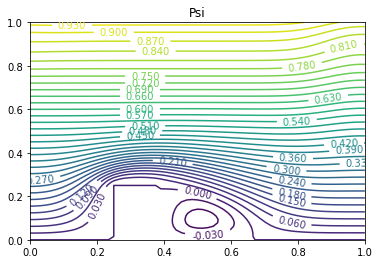

In [ ]:
plateLocation = [0.25, 0.375, 0.25] #front, back, top
world = fluidDynamics(65, 1, 0.03, plateLocation, 1)

#Using norm tolerance relative to grid spacing
#otherwise norms for larger grids would be larger
while world.norm() > (15/world.gridSpacing):
  world.sweep()
  
print("Number of sweeps:", world.sweepCount)
world.contourPlotPsi()

sweep count:  764


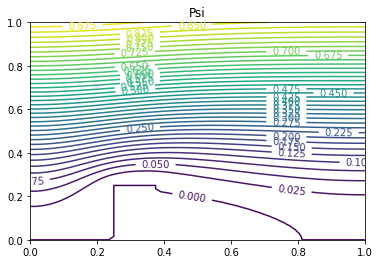

In [ ]:
plateLocation = [0.25, 0.375, 0.25] #front, back, top
world = fluidDynamics(65, 1, 0.1, plateLocation, 1)

while world.norm() > 75:#15/world.gridSpacing:
  world.sweep()

print("sweep count: ", world.sweepCount)
world.contourPlotPsi()


sweep count:  69


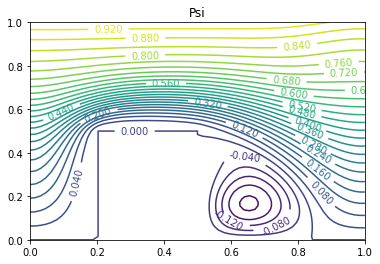

In [ ]:
plateLocation = [0.2, 0.5, 0.5] #front, back, top
world = fluidDynamics(65, 1, 0.05, plateLocation, 1)
#world.showVals()
while world.norm() > 15/world.gridSpacing:
  world.sweep()
  
#world.showVals()
print("sweep count: ", world.sweepCount)

world.contourPlotPsi()